# Stable Diffusion Inpainting

## Import

In [1]:
import torch
import random
from PIL import Image, ImageDraw
from torchvision import datasets
from diffusers import AutoPipelineForInpainting
from diffusers.utils import make_image_grid
import matplotlib.pyplot as plt

2026-01-21 21:12:18.210718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769029938.409373      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769029938.467545      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769029938.943932      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769029938.943974      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769029938.943977      55 computation_placer.cc:177] computation placer alr

## Initialisation du modèle de diffusion

On souhaite étudier l'influence du paramètre de "guidance" ($w$) sur une baseline. Pour cela, nous allons utilisé `Stable Diffusion v1.5` dans notre étude baseline.

On importe directement le modèle depuis Hugging Face.

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-inpainting",
    dtype=torch.float16,
    variant="fp16"
)
pipeline.enable_model_cpu_offload()

## Téléchargement des données

Pour notre étude, nous allons utilisé la dataset FashionMNIST. Le dataset comprend 10 classes d'objet du quotidien (t-shirt, pantalon, pull, robe, manteau, sandale, chemise, chaussure, sac, botte), en grayscale, et au format 28 x 28.

Comme `Stable Diffusion` utilise a été entraîné sur des images en 512 x 512, nous devons les redimensionner. De plus, nous ajoutons un masque pour pouvoir effectuer notre tache d'inpainting.

In [3]:
fmnist_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=None)

labels_map = {
    0: "t-shirt", 1: "trouser", 2: "pullover", 3: "dress", 4: "coat",
    5: "sandal", 6: "shirt", 7: "sneaker", 8: "bag", 9: "boot"
}

# Préparation de l'image et du masque
def prepare_data():
    # Image random de FashionMNIST
    idx = random.randint(0, len(fmnist_data) - 1)
    img_pil, label_idx = fmnist_data[idx]
    class_name = labels_map[label_idx]

    # Redimension de l'image
    init_image = img_pil.resize((512, 512), resample=Image.NEAREST).convert("RGB")

    # Création du masque aléatoire
    mask_image = Image.new("L", (512, 512), 0)
    draw = ImageDraw.Draw(mask_image)

    square_size = 200
    x = random.randint(0, 512 - square_size)
    y = random.randint(0, 512 - square_size)

    draw.rectangle([x, y, x + square_size, y + square_size], fill=255)

    return init_image, mask_image, class_name

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.59MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]


## Inférence du modèle sur FashionMNIST

### Inférence rapide sur une image

`Stable Diffusion` prend en input :
- l'image initiale
- le masque appliqué à l'image
- le prompt permettant de remplir le "trou" créé par le masque

Générons un exemple avec notre dataset. Ici on demande au modèle de reconstruire le trou de l'image comme demandé.

In [4]:
init_image, mask_image, class_name = prepare_data()

# On utilise la classe de la photo pour compléter la partie cachée de l'image
prompt = f"grayscale pixel art icon of a {class_name}, simple shape, low resolution, monochrome, flat color"

# Paramètre w (guidance_scale) :
guidance_scale = 7.5

print(f"Prompt: '{prompt}' | Class Originale: {class_name}")

# Génération de l'image
image = pipeline(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    guidance_scale=guidance_scale
).images[0]

image_with_mask = Image.composite(Image.new("RGB", init_image.size, "black"), init_image, mask_image)

Prompt: 'grayscale pixel art icon of a pullover, simple shape, low resolution, monochrome, flat color' | Class Originale: pullover


  0%|          | 0/50 [00:00<?, ?it/s]

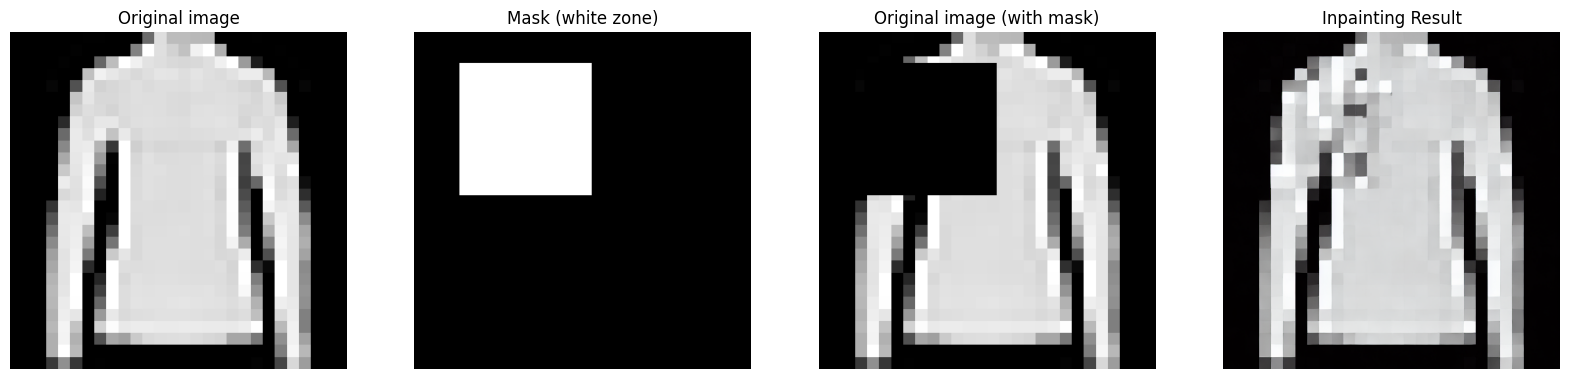

In [5]:
# On plot un exemple d'image avec w = 7.5

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(init_image)
ax[0].set_title("Original image")
ax[0].axis("off")

ax[1].imshow(mask_image, cmap="gray")
ax[1].set_title("Mask (white zone)")
ax[1].axis("off")

ax[2].imshow(image_with_mask)
ax[2].set_title("Original image (with mask)")
ax[2].axis("off")

ax[3].imshow(image)
ax[3].set_title("Inpainting Result")
ax[3].axis("off")

plt.show()

### Inférences successives

In [6]:
def inpainting_inference(nb_sample=5, w=7.5, max_retries=5):
    fig, ax = plt.subplots(nb_sample, 4, figsize=(16, 4 * nb_sample))

    if nb_sample == 1:
        ax = ax.reshape(1, -1)

    for i in range(nb_sample):
        # Preprocessing des images
        init_image_512, mask_image_512, class_name = prepare_data()

        prompt = f"grayscale pixel art icon of a {class_name}, simple shape, low resolution, monochrome, flat color"
        print(f"[{i+1}/{nb_sample}] - Prompt : '{prompt}'")

        image_hd = None
        attempts = 0

        # On boucle pour avoir des images correctes (Hugging Face nous bloque
        # pour générer du contenu NSFW)
        while attempts < max_retries:
            output = pipeline(
                prompt=prompt,
                image=init_image_512,
                mask_image=mask_image_512,
                guidance_scale=w
            )

            if hasattr(output, "nsfw_content_detected") and output.nsfw_content_detected and output.nsfw_content_detected[0] == True:
                attempts += 1
            else:
                image_hd = output.images[0]
                break

        if image_hd is None: image_hd = Image.new("RGB", (512, 512), (255, 0, 0))

        # On redimensionne les images
        generated_28 = image_hd.resize((28, 28), resample=Image.BILINEAR)
        original_28 = init_image_512.resize((28, 28), resample=Image.NEAREST)
        mask_28 = mask_image_512.resize((28, 28), resample=Image.NEAREST)

        final_28 = Image.composite(generated_28, original_28, mask_28)

        input_view_28 = Image.composite(Image.new("RGB", (28, 28), "black"), original_28, mask_28)

        # On crée notre visualisation
        ax[i, 0].imshow(original_28)
        ax[i, 0].set_title(f"Original (28x28)\n{original_28.size}")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(mask_28, cmap="gray")
        ax[i, 1].set_title(f"Masque (28x28)")
        ax[i, 1].axis("off")

        ax[i, 2].imshow(input_view_28)
        ax[i, 2].set_title(f"Input Modèle")
        ax[i, 2].axis("off")

        ax[i, 3].imshow(final_28)
        ax[i, 3].set_title(f"Résultat Final (28x28)\n{final_28.size}")
        ax[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

[1/3] - Prompt : 'grayscale pixel art icon of a coat, simple shape, low resolution, monochrome, flat color'


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

[2/3] - Prompt : 'grayscale pixel art icon of a bag, simple shape, low resolution, monochrome, flat color'


  0%|          | 0/50 [00:00<?, ?it/s]

[3/3] - Prompt : 'grayscale pixel art icon of a bag, simple shape, low resolution, monochrome, flat color'


  0%|          | 0/50 [00:00<?, ?it/s]

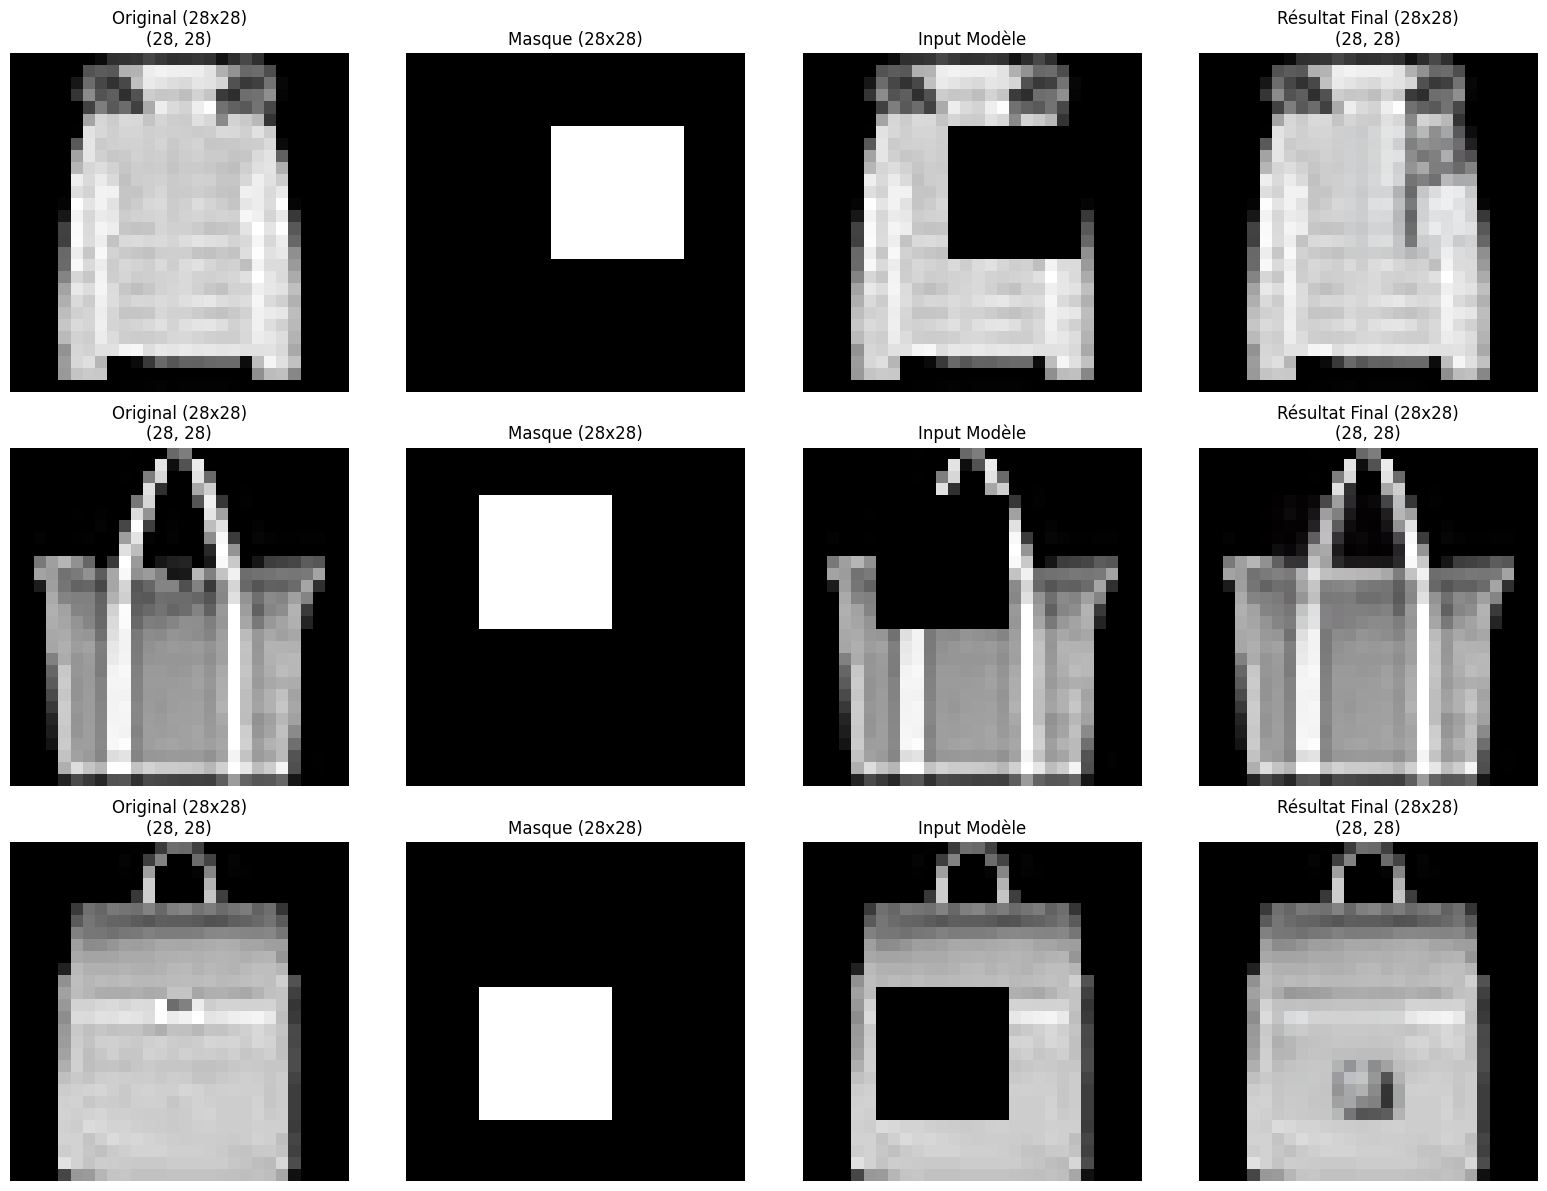

In [7]:
inpainting_inference(nb_sample=3)

## Étude du paramètres de "guidance" $w$

On définit des nouvelles fonctions pour pouvoir prendre plusieurs images et faire de l'inpainting avec différentes valeurs de $w$.

In [8]:
def pixel_crush_process(image_hd_512, original_512, mask_512):
    generated_28 = image_hd_512.resize((28, 28), resample=Image.BILINEAR)

    original_28 = original_512.resize((28, 28), resample=Image.NEAREST)
    mask_28 = mask_512.resize((28, 28), resample=Image.NEAREST)

    final_28 = Image.composite(generated_28, original_28, mask_28)

    return final_28, original_28, mask_28

def generate_safe_image(pipeline, prompt, init_image, mask_image, w, max_retries=3):
    attempts = 0

    # Génère des images en évitant les NSFW
    while attempts < max_retries:
        output = pipeline(
            prompt=prompt,
            image=init_image,
            mask_image=mask_image,
            guidance_scale=w
        )
        if hasattr(output, "nsfw_content_detected") and output.nsfw_content_detected and output.nsfw_content_detected[0] == True:
            attempts += 1
            print(f"        NSFW (w={w})... Essai {attempts}/{max_retries}")
        else:
            return output.images[0]

    # En cas d'échec, retourne une image rouge
    return Image.new("RGB", init_image.size, (255, 0, 0))

In [9]:
def visualize_guidance_impact(samples_list, w_list=[1.0, 7.5, 15.0], max_tries=3):
    """
    Génère une grille comparative pour voir l'impact de 'w'.

    Args:
        samples_list: Liste de tuples (image_512, mask_512, class_name)
        w_list: Liste des valeurs de guidance à tester
    """
    n_images = len(samples_list)
    n_w = len(w_list)
    total_cols = 2 + n_w

    fig, ax = plt.subplots(n_images, total_cols, figsize=(3 * total_cols, 3 * n_images))

    if n_images == 1:
        ax = ax.reshape(1, -1)

    for idx, (img_512, mask_512, class_name) in enumerate(samples_list):

        # On modifie notre prompt pour qu'il évite de générer la classe directement
        # et qu'il complète le trou de façon pixelisé comme sur les images de référence du datset
        prompt = f"grayscale pixel art icon of a {class_name}, simple shape, low resolution, monochrome, flat color"
        print(f"\n[{idx+1}/{n_images}] Traitement : {class_name}...")

        orig_28 = img_512.resize((28, 28), resample=Image.NEAREST)
        mask_28 = mask_512.resize((28, 28), resample=Image.NEAREST)
        input_view_28 = Image.composite(Image.new("RGB", (28, 28), "red"), orig_28, mask_28)

        # On plot nos images de référence
        ax[idx, 0].imshow(orig_28)
        ax[idx, 0].set_title(f"Original\n({class_name})")
        ax[idx, 0].axis("off")

        ax[idx, 1].imshow(input_view_28)
        ax[idx, 1].set_title("Input\n(Masqué)")
        ax[idx, 1].axis("off")

        # On boucle sur les paramètres de "guidance" (w) et on génère une image
        # pour chaque paramètre pour visualiser la différence entre adhérence et
        # créativité de notre modèle
        for i, w in enumerate(w_list):
            hd_result = generate_safe_image(pipeline, prompt, img_512, mask_512, w, max_tries)

            final_res_28, _, _ = pixel_crush_process(hd_result, img_512, mask_512)

            col_pos = 2 + i
            ax[idx, col_pos].imshow(final_res_28)
            ax[idx, col_pos].set_title(f"w = {w}")
            ax[idx, col_pos].axis("off")

    plt.tight_layout()
    plt.show()


[1/3] Traitement : sandal...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


[2/3] Traitement : shirt...


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=0.0)... Essai 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=0.0)... Essai 2/5


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=0.0)... Essai 3/5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=1.0)... Essai 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=5.0)... Essai 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=5.0)... Essai 2/5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=9.0)... Essai 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=50.0)... Essai 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=50.0)... Essai 2/5


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


        NSFW (w=50.0)... Essai 3/5


  0%|          | 0/50 [00:00<?, ?it/s]


[3/3] Traitement : boot...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

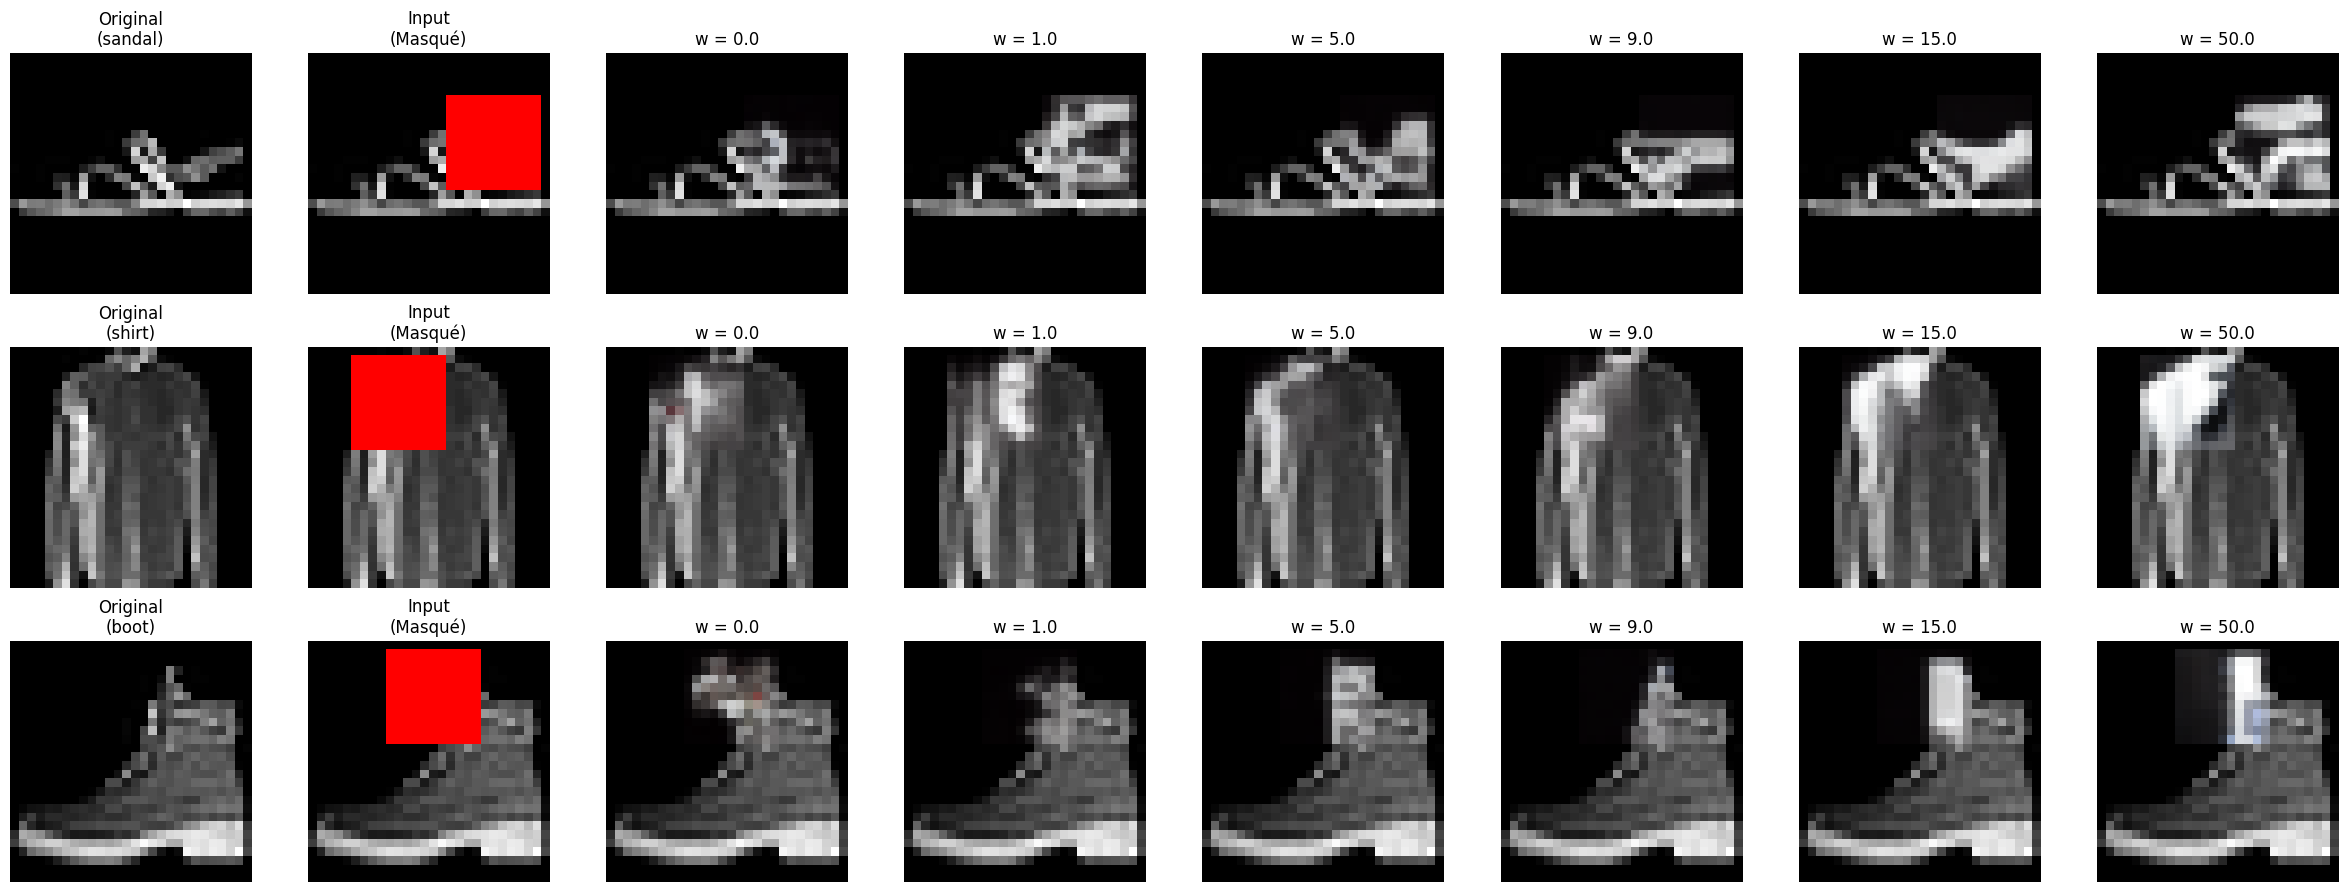

In [10]:
# On prépare les données pour ensuite faire nos inpainting
NB_DATA = 3

my_test_data = []
for _ in range(NB_DATA):
    data = prepare_data()
    my_test_data.append(data)

# Définition des paramètres de "guidance"
scales_to_test = [0.0, 1.0, 5.0, 9.0, 15.0, 50.0]

# Visualisation de nos résultats
visualize_guidance_impact(my_test_data, w_list=scales_to_test, max_tries=5)

Voici un tableau récapitulatif de l'évolution des générations suivant $w$.

Valeur de $w$ | Comportement du Modèle | Résultat Visuel (FashionMNIST) | Critique
---|---|---|---
Faible (1-3) | Priorité au Contexte. Ignore le texte regarde les pixels voisins. | Formes floues, grises, manque de définition. | Manque de créativité. Ne parvient pas à reconstruire l'objet s'il manque trop d'information.
Moyenne (7.5) | Équilibre. Écoute le texte tout en respectant l'image. | Formes claires, bonne connexion avec l'original. | Idéal. Reconstruit l'objet de manière crédible et cohérente.
Forte (15+) | Priorité au Prompt. Ignore le contexte, force l'objet. | Contraste excessif, objets complets écrasés dans le masque, incohérences spatiales. | Caricatural. Le modèle "force" l'objet au détriment de l'intégration naturelle.